In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!fc-list :lang=ko

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [4]:
plt.rc('font', family='NanumBarunGothic')

In [5]:
# 총 데이터
main_df = pd.read_excel('/content/drive/MyDrive/Project_데이터분석/완성본_v1(한류현황지수, 한류심리지수, 유가, 환율, 직선거리, 수입액,수출액,행복지수).xlsx')

In [6]:
main_df['관광인원비율'] = main_df['관광인원'] / main_df['전체인원']

In [7]:
# d2는 학습데이터로 사용할 컬럼들
# df_one_hot은 원 핫 인코딩 한 것
df2 = main_df[['날짜','국가','관광인원','score_1','score_2','Oil_Price','월평균 매매기준율','직선거리(km)','수출액[천달러]','수입액[천달러]','행복지수','관광인원비율']]
df_one_hot = pd.get_dummies(df2,columns=['국가'])
df_one_hot

,날짜,관광인원,score_1,score_2,Oil_Price,월평균 매매기준율,직선거리(km),수출액[천달러],수입액[천달러],행복지수,...,국가_미국,국가_브라질,국가_영국,국가_인도,국가_인도네시아,국가_일본,국가_중국,국가_태국,국가_프랑스,국가_호주
0,201401,230706,3.64,126.48,104.01,176.21,2118,11482348,7470240,5.140,...,0,0,0,0,0,0,1,0,0,0
1,201401,44459,3.36,104.75,104.01,35.41,1507,1309034,1216739,6.298,...,0,0,0,0,0,0,0,0,0,0
2,201401,6711,3.50,136.40,104.01,8.76,4325,1244231,1107067,5.399,...,0,0,0,0,1,0,0,0,0,0
3,201401,28365,3.58,124.33,104.01,32.34,3509,617878,387714,6.455,...,0,0,0,0,0,0,0,1,0,0
4,201401,1967,2.55,92.89,104.01,17.19,4970,938299,454411,4.565,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,202212,28358,3.64,104.75,77.22,42.23,1507,1803441,2171610,6.535,...,0,0,0,0,0,0,0,0,0,0
1508,202212,81012,3.32,71.54,77.22,959.12,943,2428656,401545,6.129,...,0,0,0,0,0,1,0,0,0,0
1509,202212,15719,3.43,126.48,77.22,185.47,2118,11197865,11810034,5.818,...,0,0,0,0,0,0,1,0,0,0
1510,202212,15703,3.00,121.56,77.22,874.34,7023,1381286,3662003,7.095,...,0,0,0,0,0,0,0,0,0,1


In [8]:
df_one_hot.to_csv('0630.csv')

In [9]:
#LGBM은 컬럼에 []들어가면 에러뜸 그래서 처리
df_one_hot = df_one_hot.rename(columns={'수출액[천달러]':'수출액','수입액[천달러]':'수입액'})

In [10]:
#학습데이터 검증데이터 만들기 (총 1500개여서 테스트사이즈 0.1로잡음)
X_train, X_test, y_train, y_test = train_test_split(df_one_hot.drop(['관광인원','관광인원비율'],axis=1), df_one_hot['관광인원'], test_size=0.1, random_state=10)

In [11]:
#하이퍼파리미터 적용X / 단순 학습
base_model = LGBMRegressor(random_state=10)
base_model.fit(X_train,y_train)

pred1 = base_model.predict(X_test)

rmse = mean_squared_error(pred1,y_test,squared=False)
print(f'rmse : {rmse}')

#테스트 데이터 1번
test1 = base_model.predict(X_test.loc[[146]])
print(f'예상 관광객 수 : {test1}')

rmse : 12829.567596364583
예상 관광객 수 : [4690.0223346]


In [12]:
#최적의 하이퍼파라미터 찾기 오래걸려서 주석

from sklearn.model_selection import RandomizedSearchCV

base_model = LGBMRegressor()
params = {
    'max_depth': [2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_leaf_nodes': [20,25,31,35,40],
    'max_iter': [50, 70, 90,100,110,130],
    'learning_rate':[0.1,0.2,0.3,0.4,0.01,0.003]
}


model = RandomizedSearchCV(base_model,params, cv=5)
model.fit(X_train,y_train)
model.best_params_

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=110, max_iter=110 will be ignored. Current value: num_iterations=110


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=110, max_iter=110 will be ignored. Current value: num_iterations=110


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=110, max_iter=110 will be ignored. Current value: num_iterations=110


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=110, max_iter=110 will be ignored. Current value: num_iterations=110


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=110, max_iter=110 will be ignored. Current value: num_iterations=110
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=70, max_iter=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [W

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=35 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=25 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=130, max_iter=130 will be ignored. Current value: num_iterations=130


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=25 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=130, max_iter=130 will be ignored. Current value: num_iterations=130


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=25 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=130, max_iter=130 will be ignored. Current value: num_iterations=130


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=25 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=130, max_iter=130 will be ignored. Current value: num_iterations=130
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=25 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=130, max_iter=130 will be ignored. Current value: num_iterations=130
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=90, max_iter=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=20 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


{'min_samples_split': 5,
 'max_leaf_nodes': 20,
 'max_iter': 100,
 'max_depth': 4,
 'learning_rate': 0.4}

In [13]:
#최적의 하이퍼파라미터 적용
model = LGBMRegressor(
min_samples_split= 7,
max_leaf_nodes= 35,
 max_iter=151,
 max_depth= 5,
learning_rate= 0.3,
random_state=10)

model.fit(X_train,y_train)
pred = model.predict(X_test)


rmse = mean_squared_error(pred,y_test,squared=False)
print(f'rmse : {rmse}')

#테스트 데이터 1번
test1 = model.predict(X_test.loc[[146,339,1356,1315,1447,145,666,1203,1218]])
print(f'예상 관광객 수 : {test1} 명')

rmse : 10986.994574479557
예상 관광객 수 : [ 5910.11062117 -3004.63617768 -5277.05437956   459.29283686
 13006.38444158  -387.13952641 13050.17389574  -100.12286568
  2459.12340214] 명


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [14]:
main_df.loc[1356]

국가                 중국
날짜             202201
관광인원             1641
상용인원              170
공용인원                8
유학인원              264
기타인원             7406
20세 이하            136
21~30세            883
31~40세           1433
41~50세            777
51~60세            982
61세이상             506
승무원              4772
전체인원             9489
score_1          3.43
score_2        126.48
Oil_Price       83.47
월평균 매매기준율      187.75
직선거리(km)         2118
수출액[천달러]     13369829
수입액[천달러]     13178864
행복지수            5.818
관광인원비율       0.172937
Name: 1356, dtype: object

In [15]:
1.428900e+04

14289.0

In [16]:
#실제 146번 인덱스의 관광객 확인해보기
df_one_hot.loc[146,'관광인원']

4889

In [17]:
#피쳐 중요도
importances=model.feature_importances_
importances

top10 = pd.DataFrame({
    'features': X_train.columns,
    'importance':importances})
top10

,features,importance
0,날짜,290
1,score_1,49
2,score_2,21
3,Oil_Price,133
4,월평균 매매기준율,132
5,직선거리(km),25
6,수출액,360
7,수입액,288
8,행복지수,68
9,국가_남아프리카공화국,0


<Axes: xlabel='importance', ylabel='features'>

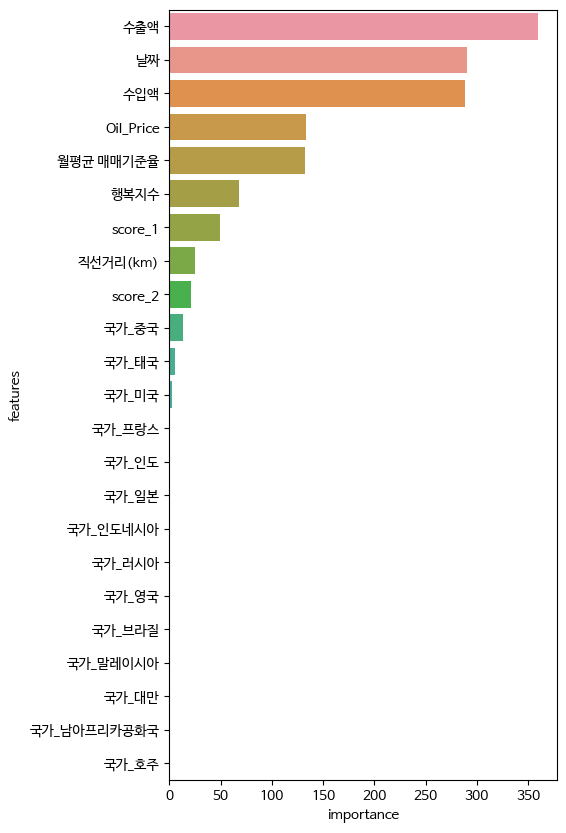

In [18]:
# 피쳐중요도 시각화
plt.figure(figsize=(5,10))
sns.barplot(x='importance',y='features', data=top10.sort_values('importance',ascending=False))

<ipython-input-24-9b2d9246df68>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(main_df.corr(),cmap='coolwarm',vmin=-1,vmax=1,annot=True)
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


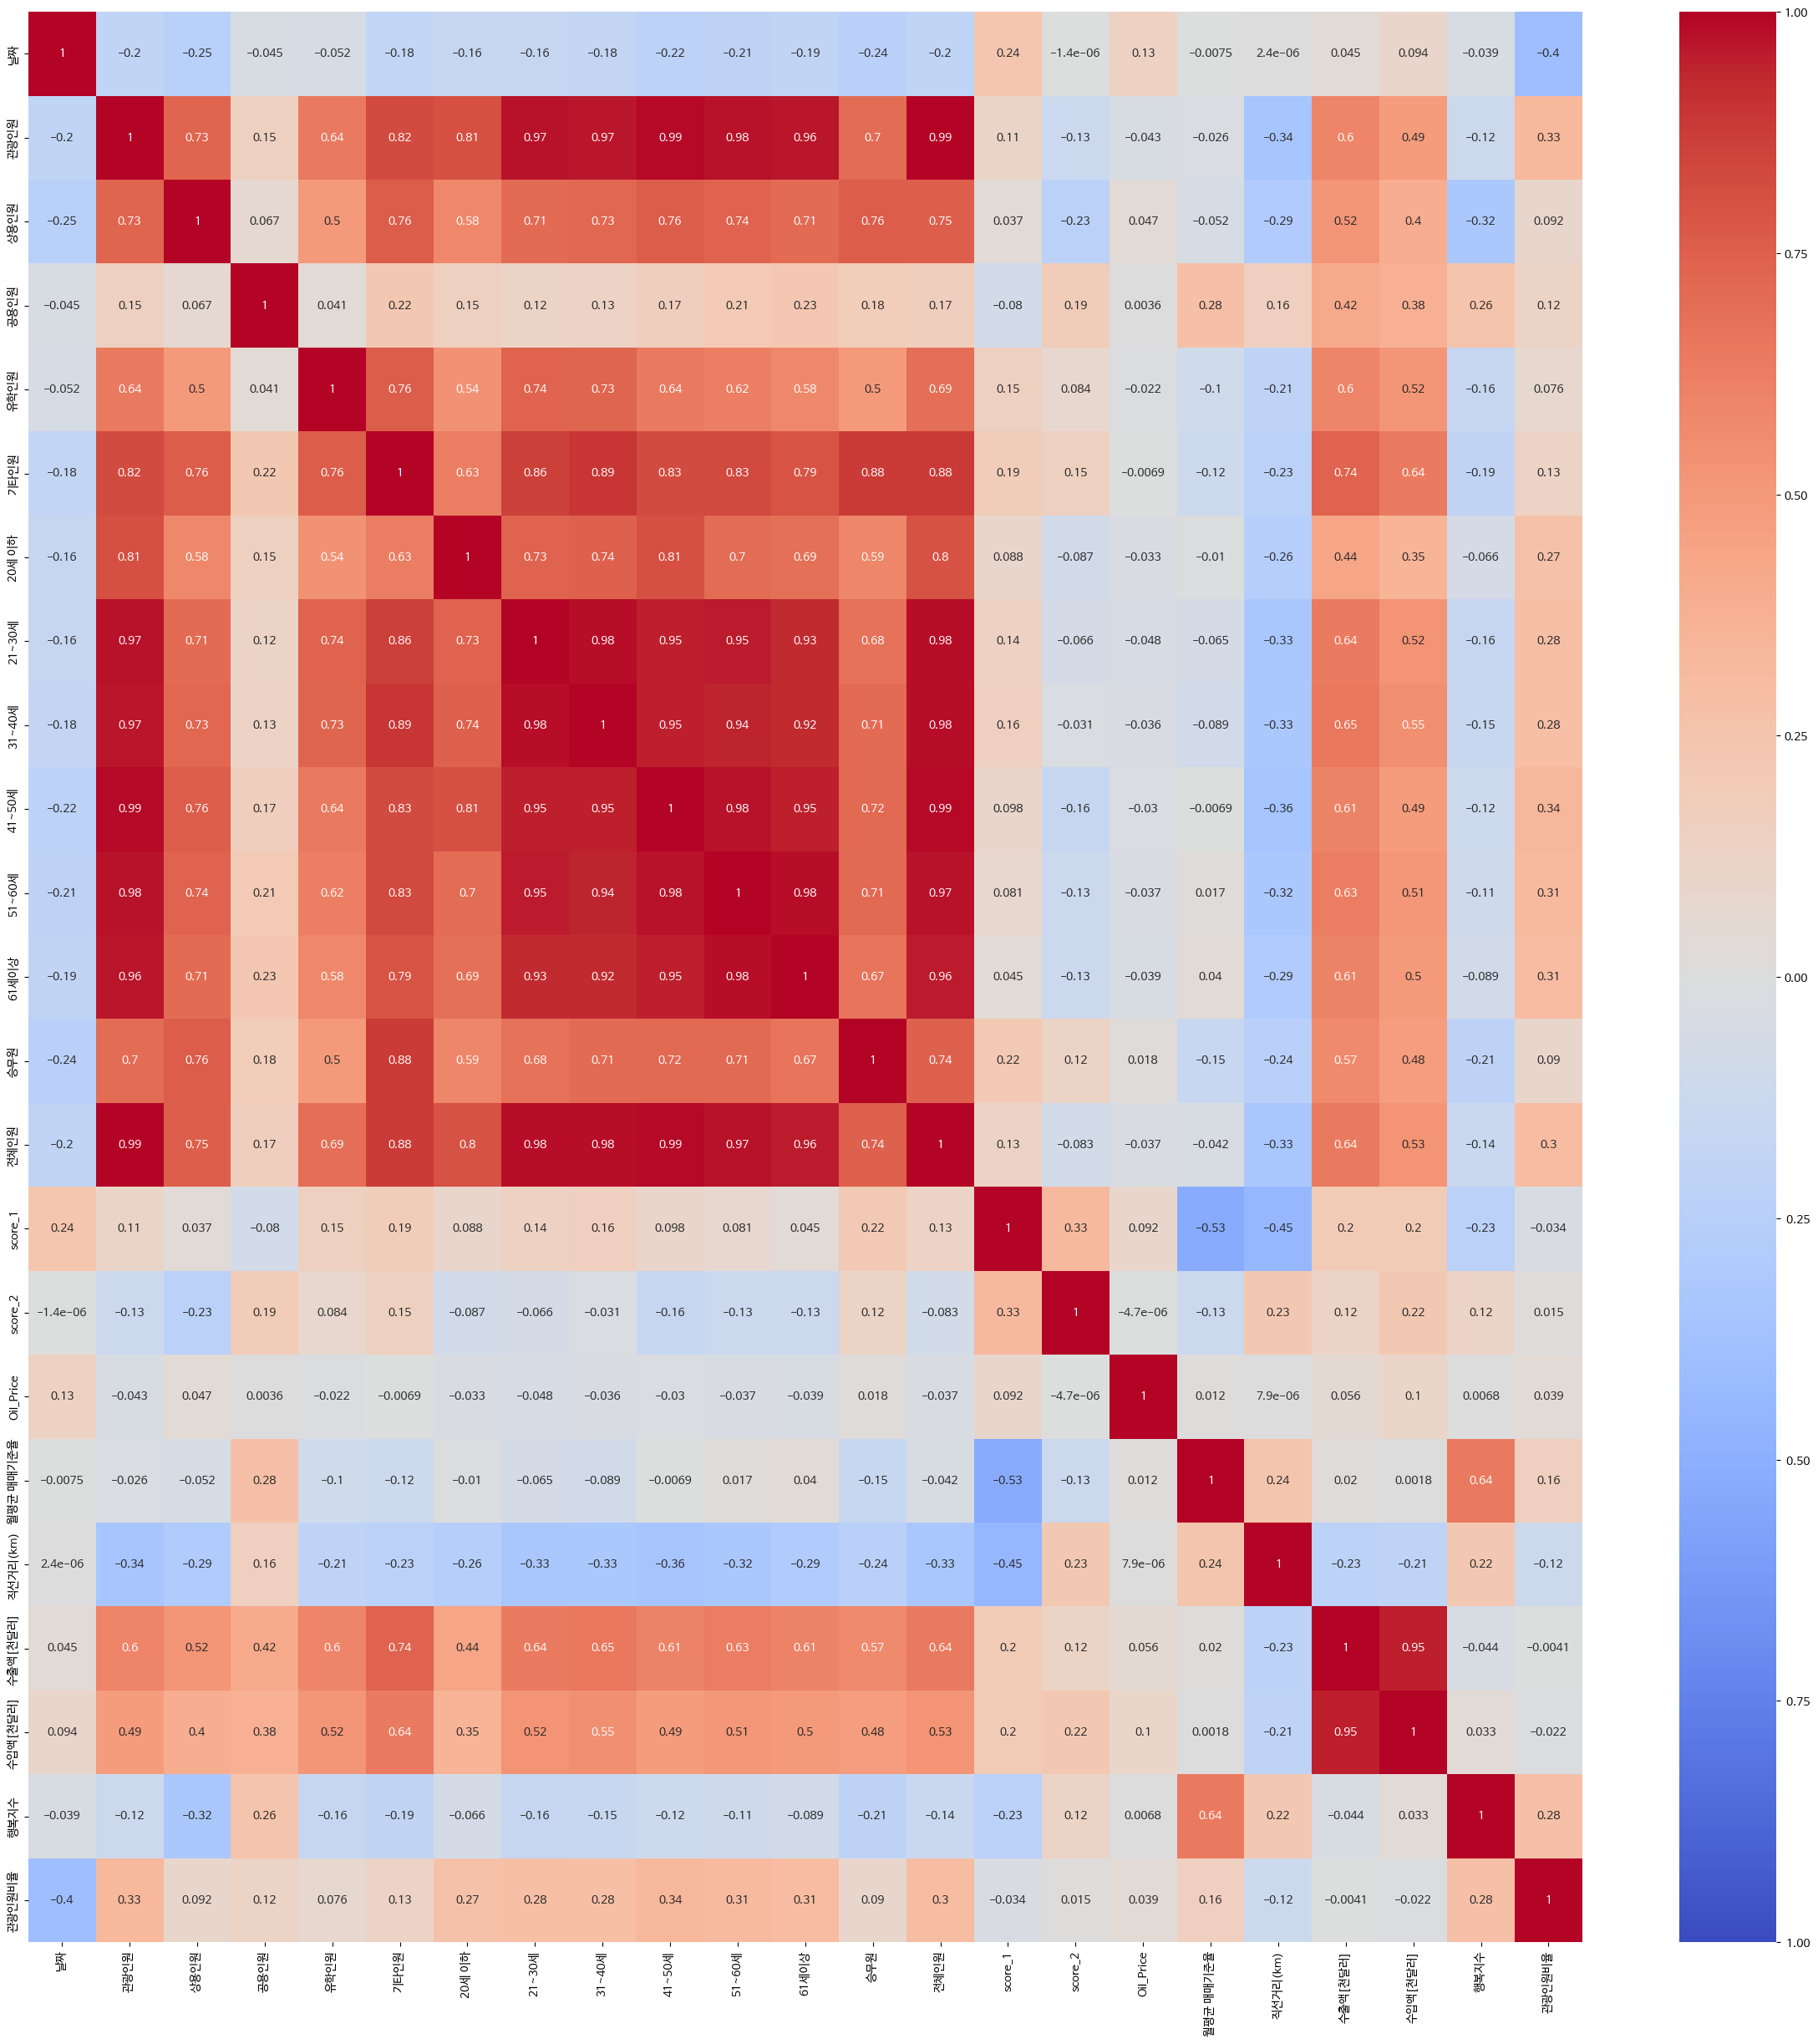

In [24]:
#상관계수확인하기 (상관계수와 피처중요도 차이 확인하려고 !)
plt.figure(figsize=(30,30))
sns.heatmap(main_df.corr(),cmap='coolwarm',vmin=-1,vmax=1,annot=True)

<Figure size 2400x1200 with 0 Axes>

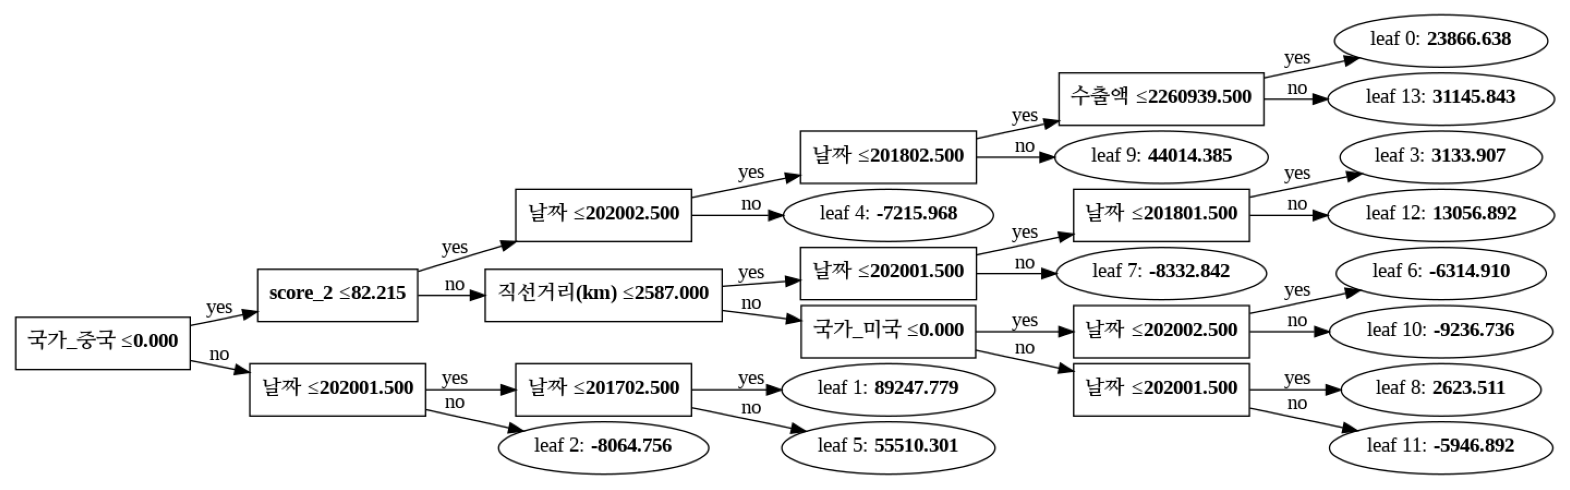

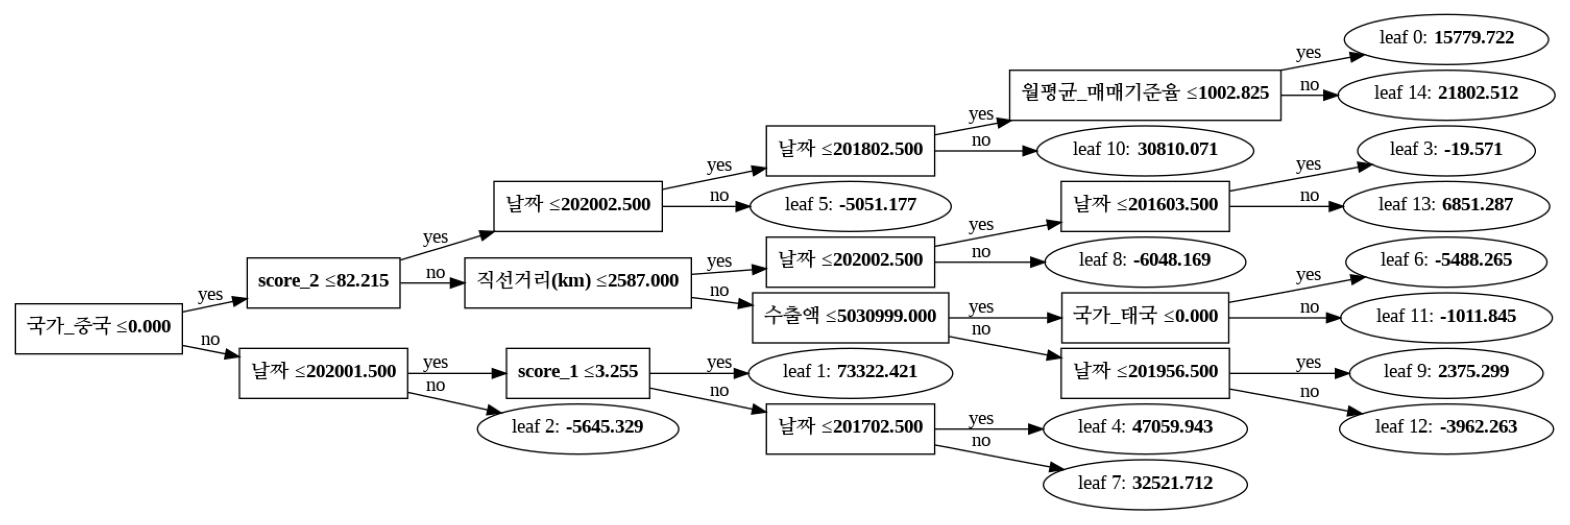

In [20]:
#나무 시각화
#(tree_index를 수정 시 다른 나무 볼 수 있음)
from sklearn.tree import plot_tree
import lightgbm as lgb

plt.figure(figsize=(24,12))
lgb.plot_tree(model, tree_index=1, figsize=(20, 12))
lgb.plot_tree(model, tree_index=2, figsize=(20, 12))
plt.show()

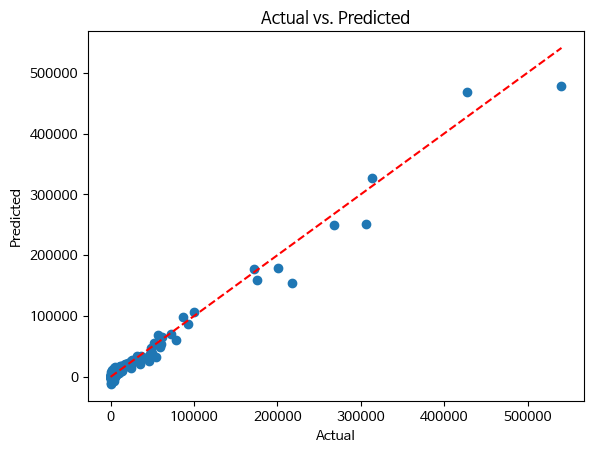

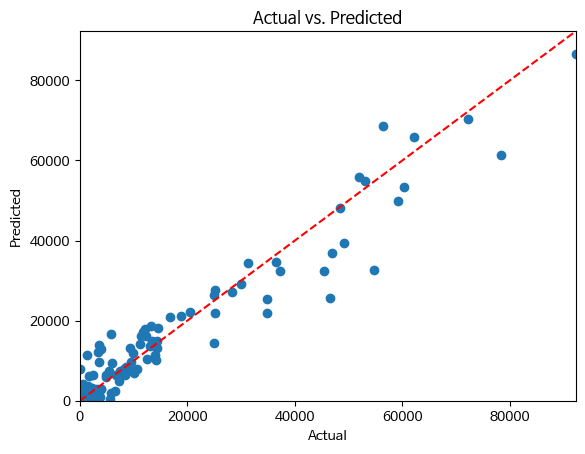

In [21]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
comparison
plt.scatter(y_test, pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()




#y_test = 테스트데이터의 # 100,000 이하의 데이터만 필터링
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
comparison = comparison[comparison['Actual'] <= 100000]

plt.scatter(comparison['Actual'], comparison['Predicted'])
plt.plot([0, max(comparison['Actual'])], [0, max(comparison['Actual'])], 'r--')
plt.xlim(0, max(comparison['Actual']))
plt.ylim(0, max(comparison['Actual']))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

# 인사이트
* 인사이트
        # LGBM분류 모델이 RMSE 14000으로 가장 오차율이 작은 모델이였다.
        피처 중요도를 보게 되면 수출액 > 날짜 > 수입액 > 유가 > 환율 > 행복지수 순이였다.

        # 피처중요도는  절대적인 지표가 되지 못한다. 하지만 상대적 영향이 있었던 컬럼을 확인 가능
        (이유: 노드를 나눌때 정보의 이득 + 지니 상수의 중요도만 고려하기때문)

        #상관계수를 보았을 때도 수입,수출액이과 높은 상관관계를 가졌다.

        따라서 관광인원을 결정하는 순서는 '수출액 > 수입액 > 유가 > 환율 > 행복지수' 순서였다.